# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import glob as gb
import cv2
import PIL
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

 Path to the Datset

In [2]:
train_path = 'C:\\Users\\sumit\\Downloads\\Skin_Cancer\\Skin_Cancer\\train'
test_path = 'C:\\Users\\sumit\\Downloads\\Skin_Cancer\\Skin_Cancer\\test'

In [4]:
# Parameters
new_size = 224
batch_size = 32
epochs = 10

# Training and Visualization of Data

In [5]:
# Function to load images from folder
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for class_name in os.listdir(folder_path):
        class_index = {'benign': 0, 'malignant': 1}
        class_path = os.path.join(folder_path, class_name)
        for img_path in gb.glob(os.path.join(class_path, '*.jpg')):
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (new_size, new_size))
            images.append(image)
            labels.append(class_index[class_name])
    return np.array(images), np.array(labels)

In [6]:
# Load train and test images
train_images, train_labels = load_images_from_folder(train_path)
test_images, test_labels = load_images_from_folder(test_path)

In [7]:
# Displaying the data and labels of images
print(f"Training data shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training data shape: (50, 224, 224, 3)
Training labels shape: (50,)
Test data shape: (50, 224, 224, 3)
Test labels shape: (50,)


# Visualization of Data and Pixels

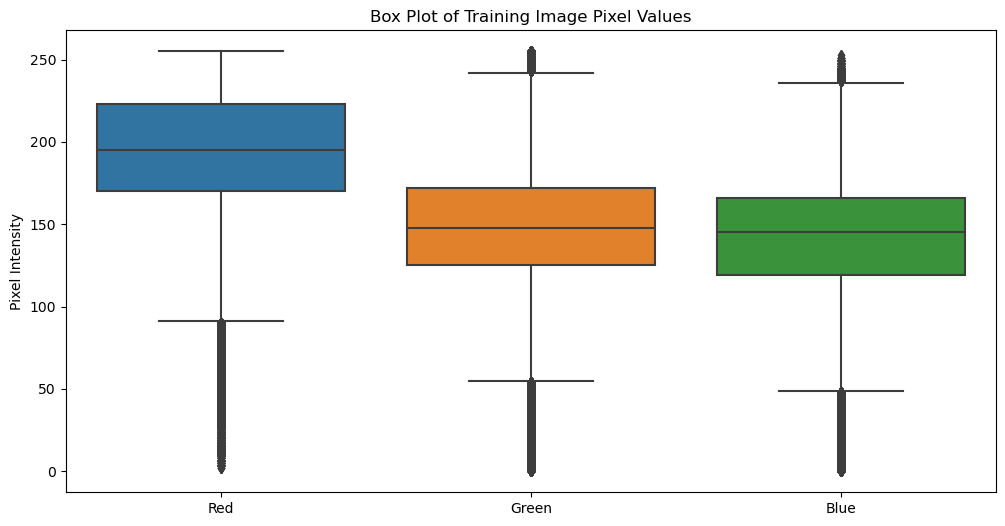

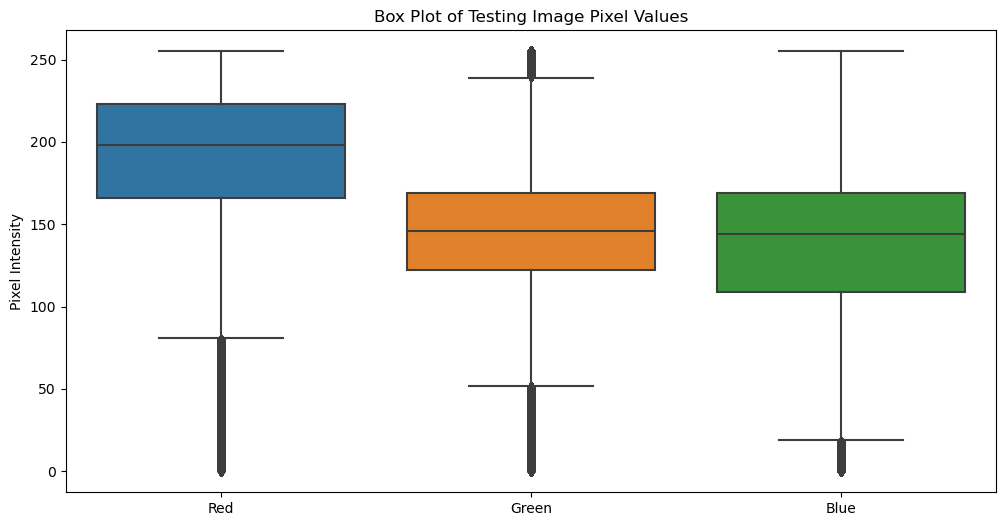

In [8]:
# Box Plot Visualization of Pixel Values
def plot_box_plots(images, title):
    # Flatten the images to get pixel values
    pixel_values = images.reshape(-1, images.shape[-1])
    # Create a DataFrame for easier plotting
    pixel_df = pd.DataFrame(pixel_values, columns=['Red', 'Green', 'Blue'])
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pixel_df)
    plt.title(title)
    plt.ylabel('Pixel Intensity')
    plt.show()

plot_box_plots(train_images, 'Box Plot of Training Image Pixel Values')
plot_box_plots(test_images, 'Box Plot of Testing Image Pixel Values')


In [2]:
# Box Plot Visualization of Pixel Values
# The box plots display the distribution of pixel intensities for the red, green, and blue channels 
# in both the training and testing datasets. 
# Observations:
# 1. The median pixel intensity for the red channel is around 200, for the green and blue channels it is around 150.
# 2. The interquartile range (IQR) for the red channel is approximately 150-250, and for the green and blue channels it is 100-200.
# 3. Both datasets have similar distributions, indicating consistency between training and testing data.
# 4. Outliers on the lower end are present in all channels, suggesting the presence of darker regions or shadows in some images.

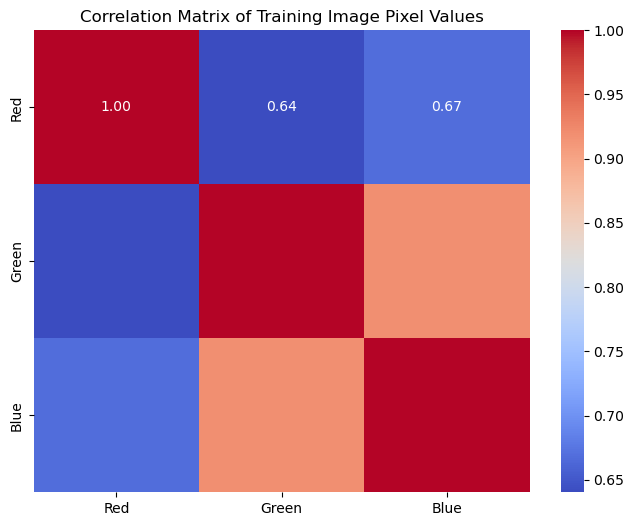

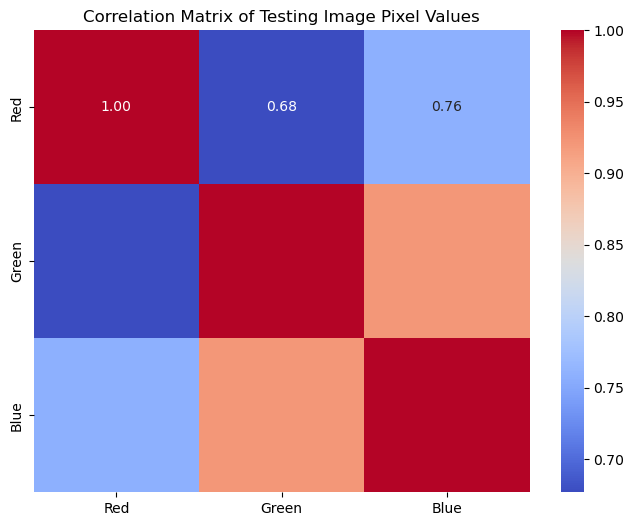

In [10]:
# Correlation Matrix Visualization of Pixel Values
def plot_correlation_matrix(images, title):
    # Flatten the images to get pixel values
    pixel_values = images.reshape(-1, images.shape[-1])
    # Create a DataFrame for easier computation of the correlation matrix
    pixel_df = pd.DataFrame(pixel_values, columns=['Red', 'Green', 'Blue'])
    
    # Compute the correlation matrix
    corr_matrix = pixel_df.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

plot_correlation_matrix(train_images, 'Correlation Matrix of Training Image Pixel Values')
plot_correlation_matrix(test_images, 'Correlation Matrix of Testing Image Pixel Values')

In [ ]:
# Correlation Matrix of Training Image Pixel Values
# The correlation matrix shows the relationship between the pixel intensities of the red, green, and blue channels 
# in the training dataset.
# Observations:
# 1. The diagonal values are 1.00, indicating perfect correlation of each channel with itself.
# 2. The correlation between the red and green channels is 0.64, and between the red and blue channels is 0.67.
# 3. The correlation between the green and blue channels is 0.72.
# 4. These positive correlations suggest that changes in the intensity of one channel are moderately associated 
#    with changes in the intensities of the other channels.
# 5. Understanding these correlations is important as it gives insights into the color composition and relationships 
#    within the images, which can affect model performance and preprocessing steps.


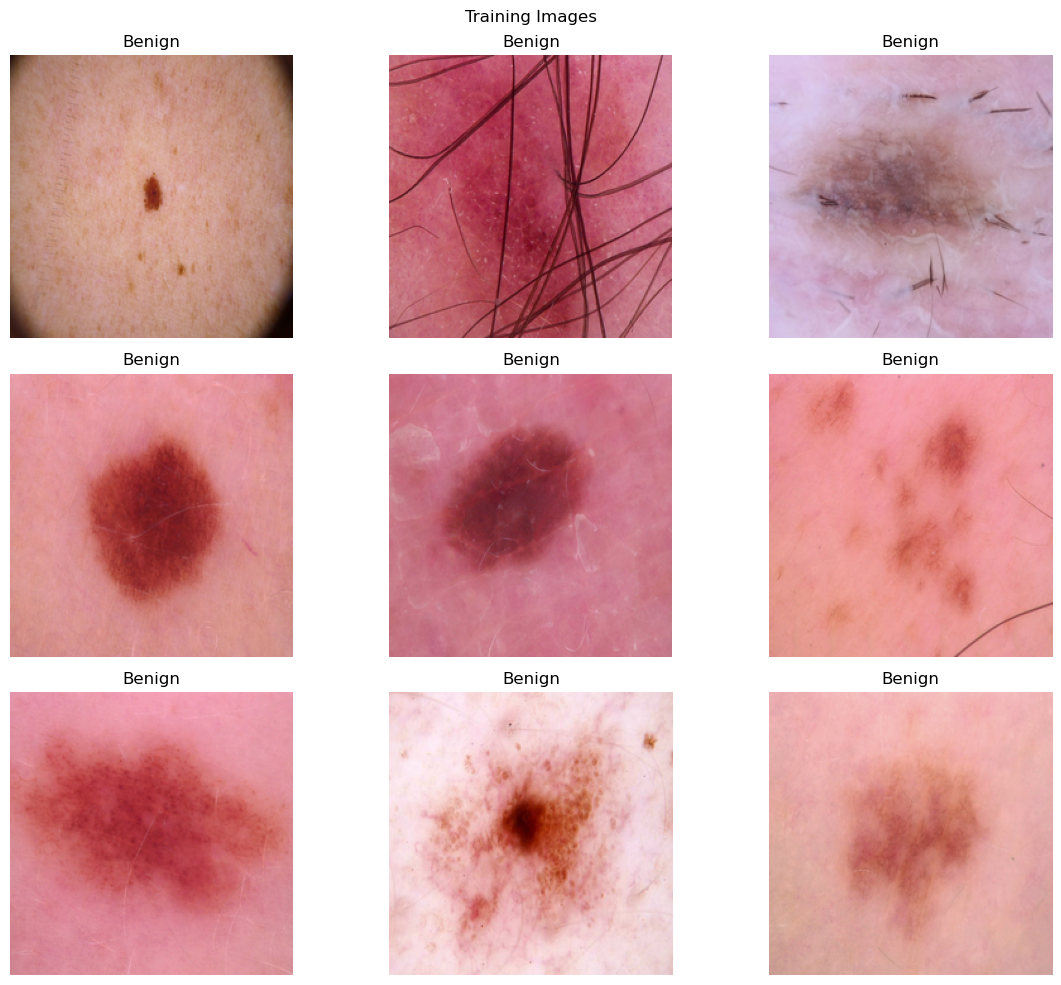

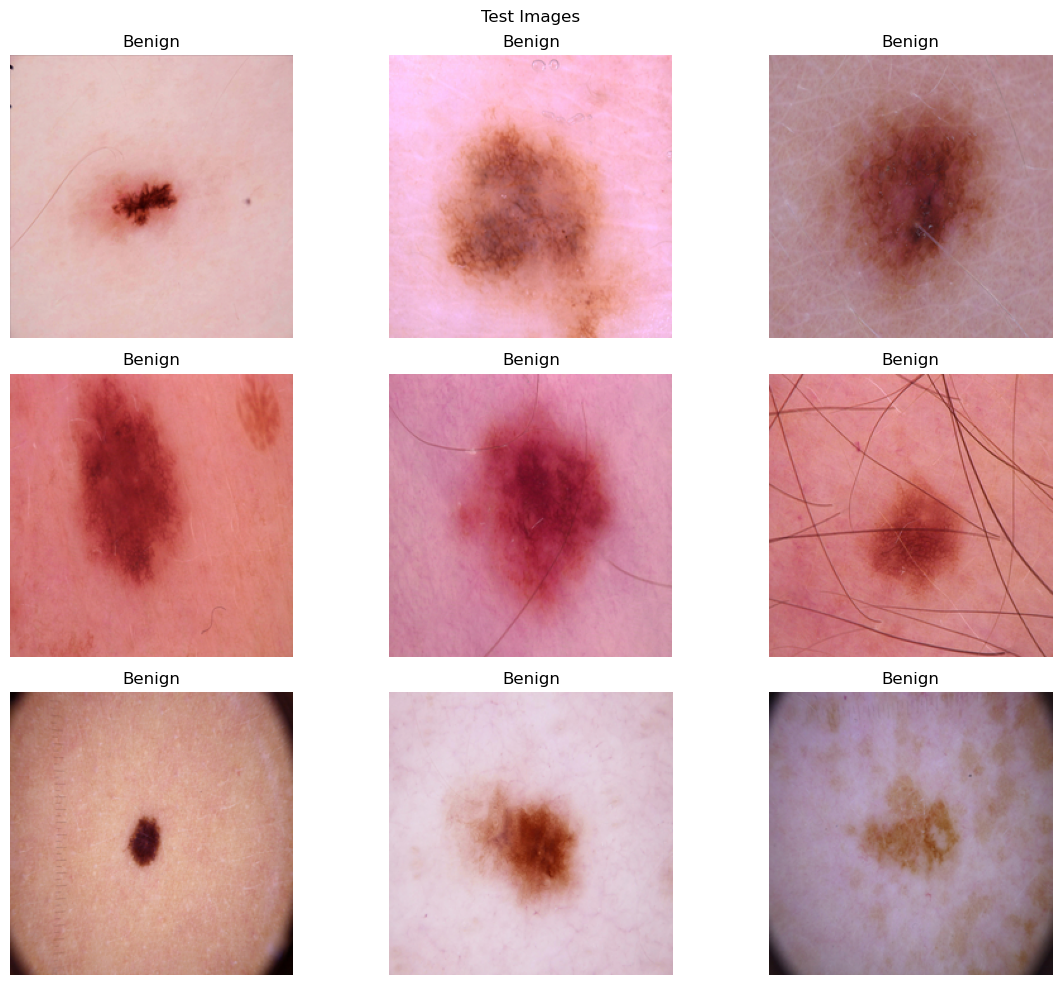

In [11]:
# Visualization of images
def plot_images(images, labels, title):
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    for ax, img, label in zip(axes.flatten(), images[:9], labels[:9]):
        ax.imshow(img)
        ax.set_title('Benign' if label == 0 else 'Malignant')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_images(train_images, train_labels, 'Training Images')
plot_images(test_images, test_labels, 'Test Images')

# Histogram

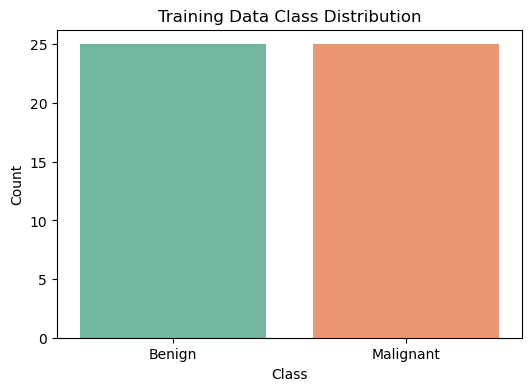

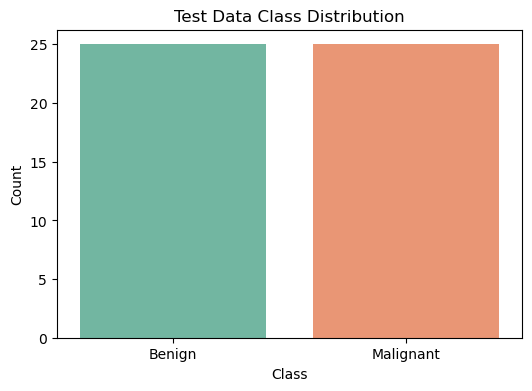

In [12]:
# Plotting histogram of class distribution
def plot_class_distribution(labels, title):
    benign_count = np.sum(labels == 0)
    malignant_count = np.sum(labels == 1)
    plt.figure(figsize=(6, 4))
    sns.countplot(x=labels, palette='Set2')
    plt.xticks([0, 1], ['Benign', 'Malignant'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Plot class distribution for training and test data
plot_class_distribution(train_labels, 'Training Data Class Distribution')
plot_class_distribution(test_labels, 'Test Data Class Distribution')

In [13]:
# Convert labels to categorical
def preprocess_labels(y_train, y_test):
    return to_categorical(y_train), to_categorical(y_test)

train_labels_cat, test_labels_cat = preprocess_labels(train_labels, test_labels)

Decision Tree Test Accuracy: 74.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.73        25
           1       0.73      0.76      0.75        25

    accuracy                           0.74        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.74      0.74      0.74        50



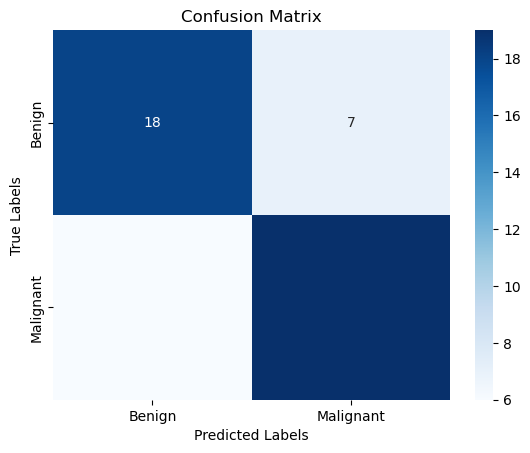

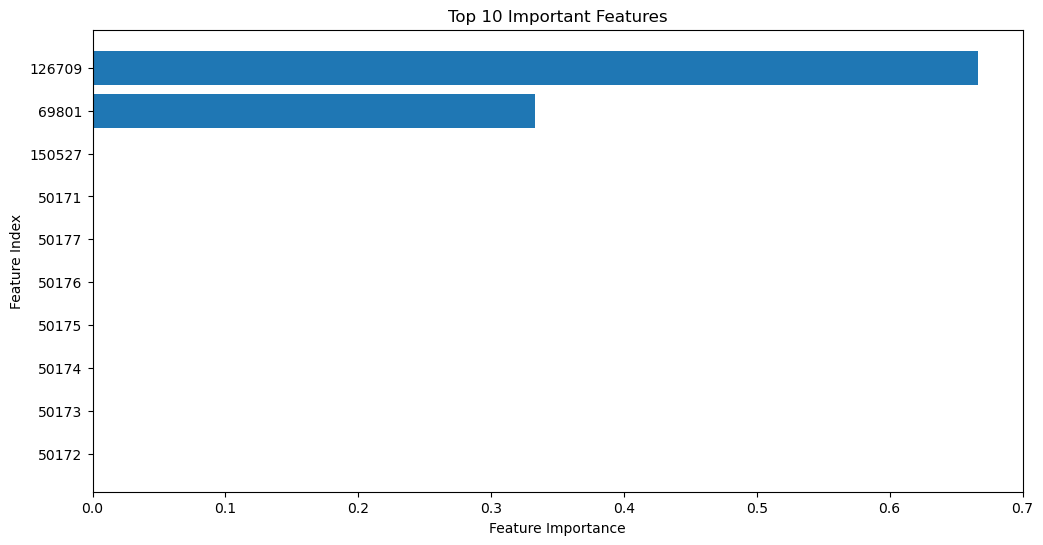

In [14]:
# Flatten images for the Decision Tree
train_images_flattened = train_images.reshape(train_images.shape[0], -1) #The images are reshaped into 2D arrays, where each image is flattened into a single row. 
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

# Train Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(train_images_flattened, train_labels)

# Evaluation on the test set
dt_predictions = dt_classifier.predict(test_images_flattened)
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print(f"Decision Tree Test Accuracy: {dt_accuracy * 100:.2f}%")

# Classification Report
print("Classification Report:\n", classification_report(test_labels, dt_predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, dt_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
feature_importances = dt_classifier.feature_importances_
important_features = np.argsort(feature_importances)[-10:]  # Get the indices of the top 10 important features
plt.figure(figsize=(12, 6))
plt.barh(range(len(important_features)), feature_importances[important_features], align='center')
plt.yticks(range(len(important_features)), important_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('Top 10 Important Features')
plt.show()


In [4]:
def model():
    base model = VGG16(weight ='imagenet', include_top = False, input_shape=(new_size, new_size, 3))
    

# Model Definition

In [15]:
# Model Definition of VGG16
def build_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(new_size, new_size, 3))
    for layer in base_model.layers:
        layer.trainable = False # Freeze all layers of VGG-16

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dense(32, activation='sigmoid', kernel_initializer='glorot_uniform')(x)
    output = Dense(2, activation='softmax', kernel_initializer='glorot_uniform')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [16]:
# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(train_images, train_labels_cat, batch_size=batch_size)

# Training and Compilation of Model

In [17]:
# Compile and Train Model
def compile_and_train_model(model, X_train, y_train, X_val, y_val):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return model, history

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_cat, test_size=0.2, random_state=42)

model = build_vgg16_model()
model, history = compile_and_train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5333 - loss: 0.7053 - val_accuracy: 0.7000 - val_loss: 0.6667 - learning_rate: 0.0010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7063 - loss: 0.5548 - val_accuracy: 0.7000 - val_loss: 0.6551 - learning_rate: 0.0010
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8750 - loss: 0.4717 - val_accuracy: 0.7000 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9729 - loss: 0.4152 - val_accuracy: 0.7000 - val_loss: 0.6127 - learning_rate: 0.0010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9729 - loss: 0.3812 - val_accuracy: 0.7000 - val_loss: 0.6054 - learning_rate: 0.0010
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9729 - loss: 0.3507 - val_accuracy: 0.7000 - val_loss: 0.5952 - learning_rate: 0.0010
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9729 - loss: 0.3159 - val_accuracy: 0.7000 - val_loss: 0.

In [ ]:
#  Model Training and Evaluation

# The model was trained over 10 epochs with early stopping and learning rate reduction callbacks. Here's a summary of the results:

#  Training and Validation Accuracy
# - Training Accuracy: The model achieved a high training accuracy of 97.19% by the 10th epoch, indicating it learned the training data very well.
# - Validation Accuracy: The validation accuracy remained relatively stable at 70.00% for most epochs, with a brief increase to 80.00% in the 8th epoch.

#  Training and Validation Loss
# - Training Loss: The training loss decreased steadily from 0.7053 to 0.2353, demonstrating effective learning.
# - Validation Loss: The validation loss also decreased from 0.6667 to 0.5674, but not as significantly as the training loss.

# Learning Rate Adjustment
# - The `ReduceLROnPlateau` callback effectively reduced the learning rate when the validation loss plateaued, ensuring the model continued to learn and adjust.


# Model Evaluation

In [18]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(test_images, test_labels_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 80.00%


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


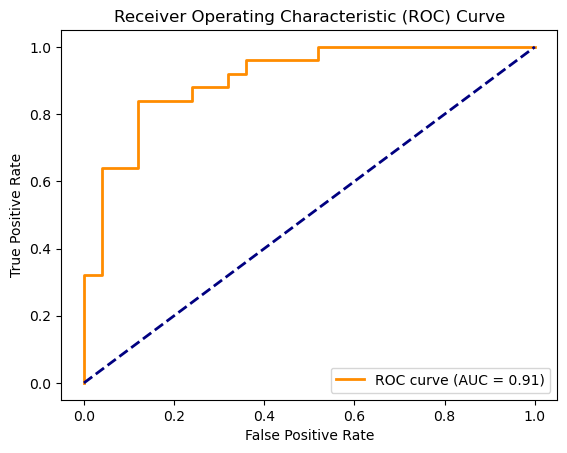

In [19]:
# Calculation of  ROC curve and AUC
y_pred_prob = model.predict(test_images)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob[:, 1])  # Use test_labels directly, and index y_pred_prob for probabilities of class 1
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# ROC Curve and AUC Analysis

# The ROC curve and AUC are used to evaluate the performance of our classification model. Here's a summary of the results:

#  ROC Curve
# The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The curve helps in visualizing the trade-off between sensitivity and specificity.

# - True Positive Rate (TPR): The ratio of correctly predicted positive observations to all observations in the actual class.
# - False Positive Rate (FPR): The ratio of incorrectly predicted positive observations to all observations in the actual negative class.

#  AUC Score
# The Area Under the Curve (AUC) provides a single value summary of the model's performance. An AUC score close to 1.0 indicates excellent model performance.

# - AUC = 0.91: Our model achieved an AUC score of 0.91, indicating a very good ability to distinguish between positive and negative classes. This high AUC score suggests that the model has a high capability of correctly classifying the classes.

# Conclusion
# The ROC curve and AUC score show that our model performs very well in distinguishing between the classes. The high AUC score of 0.91 indicates that our model has a strong predictive power. This analysis confirms that the model is capable of effectively identifying positive cases while minimizing false positive rates.

# By visualizing the ROC curve and calculating the AUC, we gain valuable insights into the model's performance, helping us to understand its strengths and areas for improvement.


# Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


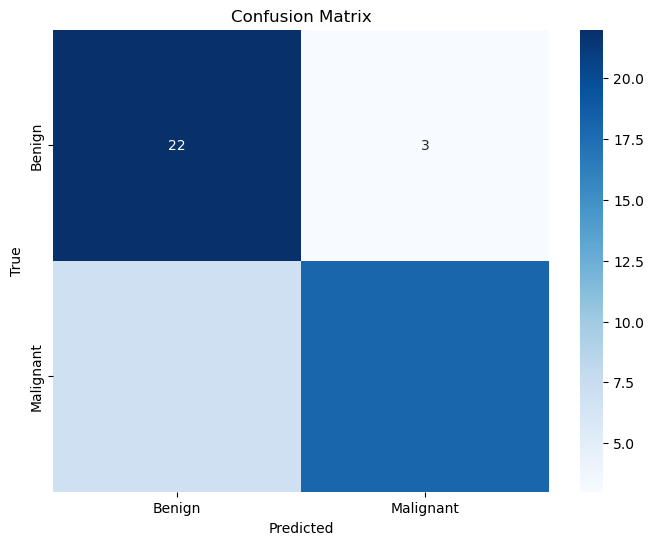

In [20]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Get predictions
y_test_pred = np.argmax(model.predict(test_images), axis=1)
plot_confusion_matrix(test_labels, y_test_pred, 'Confusion Matrix')


In [ ]:
#  Confusion Matrix Analysis

# The confusion matrix provides a comprehensive understanding of our classification model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.

#  Confusion Matrix
# |              | Predicted Benign | Predicted Malignant |
# |--------------|------------------|---------------------|
# | True Benign  | 22               | 3                   |
# |True Malignant| 0                | 25                  |

# Classification Report

In [21]:
# Classification Report
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['Benign', 'Malignant'])
    print(report)

print_classification_report(test_labels, y_test_pred)

              precision    recall  f1-score   support

      Benign       0.76      0.88      0.81        25
   Malignant       0.86      0.72      0.78        25

    accuracy                           0.80        50
   macro avg       0.81      0.80      0.80        50
weighted avg       0.81      0.80      0.80        50



In [ ]:
# ### Classification Report Analysis

# The classification report provides a detailed insight into the performance of our model for predicting benign and malignant cases. Below is a comprehensive analysis of the results:

# Class-wise Performance:

# - Benign Class:
#   - Precision: 0.76
#     - 76% of the instances predicted as benign are indeed benign. This indicates a moderate rate of false positives.
#   - Recall: 0.88
#     - The model correctly identifies 88% of the actual benign cases. This high recall suggests the model is effective at detecting benign cases.
#   - F1-Score: 0.81
#     - The F1-score of 0.81 reflects a good balance between precision and recall for the benign class.
#   - Support: 25
#     - There are 25 actual instances of benign cases in the dataset.

# - Malignant Class:
#   - Precision: 0.86
#     - 86% of the instances predicted as malignant are actually malignant. This high precision indicates a low rate of false positives.
#   - Recall: 0.72
#     - The model correctly identifies 72% of the actual malignant cases. The recall is lower than that for benign cases, indicating some malignant cases are missed.
#   - F1-Score: 0.78
#     - The F1-score of 0.78 indicates a reasonable balance between precision and recall for the malignant class, though slightly lower than for benign.
#   - Support: 25
#     - There are 25 actual instances of malignant cases in the dataset.

# Overall Performance:

# - Accuracy: 0.80
#   - The model achieves an overall accuracy of 80%, meaning it correctly classifies 80% of all instances.
# - Macro Average:
#   - Precision: 0.81, Recall: 0.80, F1-Score: 0.80
#   - The macro average provides an unweighted average of the metrics for each class. The values indicate balanced performance across both classes.
# - Weighted Average:
#   - Precision: 0.81, Recall: 0.80, F1-Score: 0.80
#   - The weighted average accounts for the number of instances in each class, confirming the balanced performance indicated by the macro average.

# Analysis:

# - The model shows a good balance between precision and recall for both benign and malignant classes.
# - Higher precision for the malignant class suggests the model is more confident when predicting malignant cases.
# - The recall for malignant cases is lower compared to benign cases, indicating the model misses some malignant instances.



# Plotting of Training History

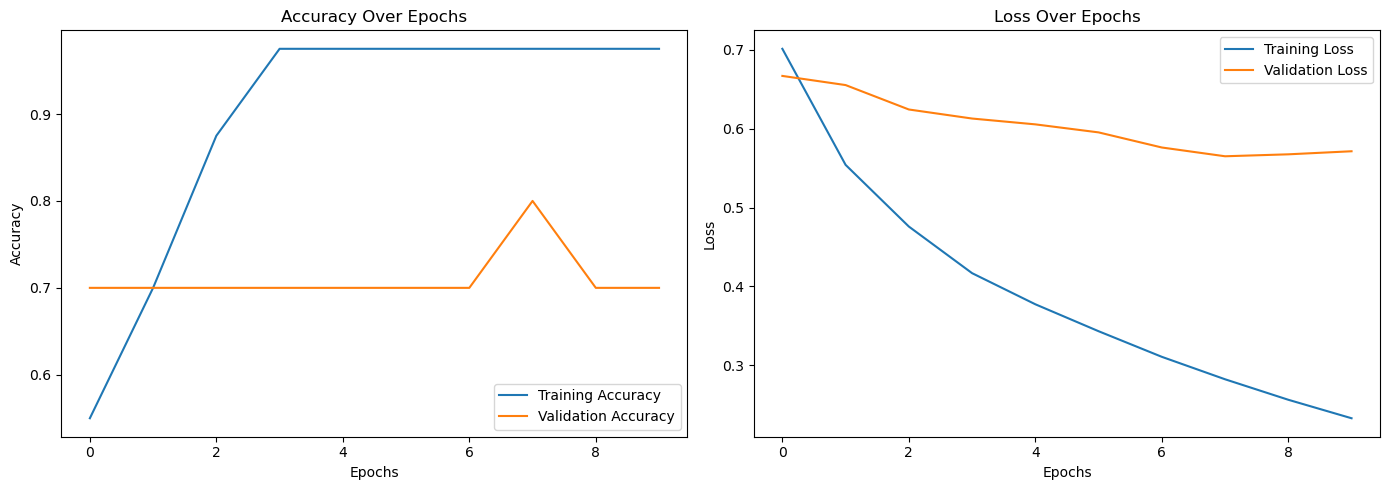

In [23]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
#  Training History Analysis

# The following plots illustrate the training and validation accuracy and loss over epochs, providing insights into the model's learning process.

# Accuracy Over Epochs:

# - Training Accuracy:
#   - The training accuracy increases steadily over the epochs, reaching close to 1.0. This suggests that the model is learning and fitting well to the training data.
# - Validation Accuracy:
#   - The validation accuracy remains relatively stable, hovering around 0.7, with a slight increase and subsequent decrease. This stability indicates that the model's performance on unseen data does not improve significantly after the initial epochs.

# Loss Over Epochs:

# - Training Loss:
#   - The training loss decreases consistently over the epochs, indicating that the model is minimizing the error on the training data.
# - Validation Loss:
#   - The validation loss shows a decreasing trend initially, followed by a plateau and a slight increase. This pattern suggests potential overfitting, where the model performs well on the training data but does not generalize as effectively to the validation data.

# Analysis:

# - Overfitting:
#   - The divergence between training accuracy and validation accuracy, along with the validation loss plateauing and increasing, indicates that the model might be overfitting to the training data. Overfitting occurs when the model captures noise and details specific to the training data, reducing its ability to generalize to new data.
# - Model Generalization:
#   - The relatively stable validation accuracy and increasing validation loss highlight the need for techniques to improve model generalization. These techniques can help the model perform better on unseen data.



# Prediction of Cancer Images

In [24]:
# Prediction on New Data
def predict_image(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (new_size, new_size))
    image = np.expand_dims(image, axis=0) / 255.0

    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)
    return 'Benign' if predicted_class[0] == 0 else 'Malignant'

In [26]:
# Example usage of a Skin Cnacer Images Detection
new_image_path = 'C:\\Users\\sumit\\Downloads\\Skin_Cancer\\Skin_Cancer\\train\\benign\\6.jpg'
predicted_class = predict_image(model, new_image_path)
print(f"Predicted Class for the new image: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Predicted Class for the new image: Benign


Hence, the model successfully predicted the images of the class Benign, which was the final goal of our project. The model's 80% accuracy can be increased in future and as of now, this project can be implemented for classification of binary images.